<a href="https://colab.research.google.com/github/frankyehtw/hello-world/blob/master/%E3%80%8CPre_trained_ResNet50_model_for_Image_classification_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-11-21 14:28:33--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.128, 74.125.26.128, 108.177.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   197MB/s    in 0.3s    

2021-11-21 14:28:34 (197 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

## Preparing the Dataset

我們將首先準備資料集並分開影像：
我們首先將文件夾內容分為train和validation目錄。
然後，在每個目錄中，為貓的影像的貓創建一個單獨的目錄，為狗的影像創建一個單獨的目錄。

In [ ]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

以下程式碼將讓我們檢查影像是否已正確載入：

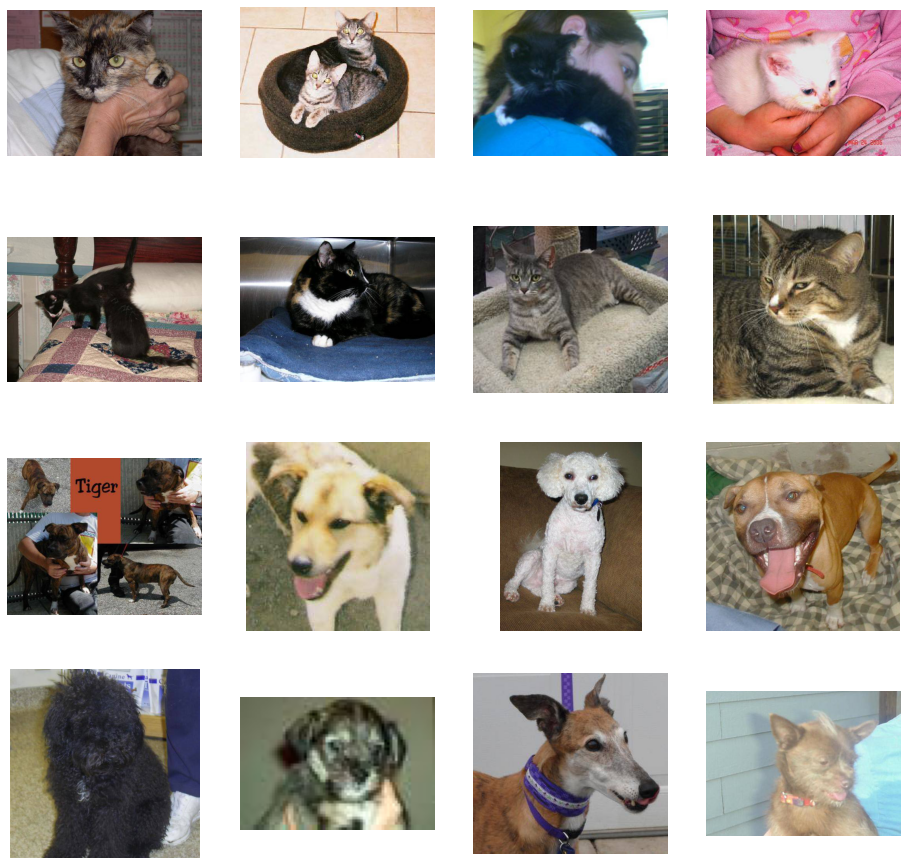

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )


next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Image Augmentation

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

更改target_size

In [ ]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(150, 150,3), include_top=False, weights="imagenet")

我們只改變最後的layer

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
inc_history = model.fit_generator(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/10
100/100 [==============================] - 238s 2s/step - loss: 0.6860 - acc: 0.5460 - val_loss: 0.6685 - val_acc: 0.5940
Epoch 2/10
100/100 [==============================] - 237s 2s/step - loss: 0.6843 - acc: 0.5585 - val_loss: 0.6694 - val_acc: 0.5970
Epoch 3/10
100/100 [==============================] - 237s 2s/step - loss: 0.6860 - acc: 0.5655 - val_loss: 0.6683 - val_acc: 0.6050
Epoch 4/10
100/100 [==============================] - 241s 2s/step - loss: 0.6843 - acc: 0.5610 - val_loss: 0.6743 - val_acc: 0.5800
Epoch 5/10
100/100 [==============================] - 240s 2s/step - loss: 0.6887 - acc: 0.5450 - val_loss: 0.6721 - val_acc: 0.6060
Epoch 6/10
100/100 [==============================] - 238s 2s/step - loss: 0.6873 - acc: 0.5525 - val_loss: 0.6714 - val_acc: 0.5980
Epoch 7/10
100/100 [==============================] - 238s 2s/step - loss: 0.6826 - acc: 0.5625 - val_loss: 0.6723 - val_acc: 0.5830
Epoch 8/10
100/100 [==============================] - 237s 2s/step - 